In [2]:
players  <- read.csv("players.csv", check.names = TRUE)
sessions <- read.csv("sessions.csv", check.names = TRUE)

cat("players: ", nrow(players), "rows x", ncol(players), "cols\n")
cat("sessions:", nrow(sessions), "rows x", ncol(sessions), "cols\n")

#creating a list of all the variables appearing at the moment, figuring out what is and isn't important for 
#the analysis I'm aiming to do
var_dict <- data.frame( 
  table   = c(rep("players",7), rep("sessions",5)),
  variable= c("experience","subscribe","hashedEmail","played_hours","name","gender","Age",
              "hashedEmail","start_time","end_time","original_start_time","original_end_time"),
  type    = c("factor","logical","id","numeric","string","factor","numeric",
              "id","string","string","numeric","numeric"),
  meaning = c("Experience tier","Has subscription","Join key","Lifetime hours","Given name",
              "Self-reported gender","Age in years",
              "Join key","Session start (d/m/Y H:M)","Session end (d/m/Y H:M)",
              "Start epoch (ms)","End epoch (ms)")
)
print(var_dict)

players:  196 rows x 7 cols
sessions: 1535 rows x 5 cols
      table            variable    type                   meaning
1   players          experience  factor           Experience tier
2   players           subscribe logical          Has subscription
3   players         hashedEmail      id                  Join key
4   players        played_hours numeric            Lifetime hours
5   players                name  string                Given name
6   players              gender  factor      Self-reported gender
7   players                 Age numeric              Age in years
8  sessions         hashedEmail      id                  Join key
9  sessions          start_time  string Session start (d/m/Y H:M)
10 sessions            end_time  string   Session end (d/m/Y H:M)
11 sessions original_start_time numeric          Start epoch (ms)
12 sessions   original_end_time numeric            End epoch (ms)


In [3]:
fmt <- "%d/%m/%Y %H:%M"
st <- strptime(sessions$start_time, fmt, tz="UTC")
en <- strptime(sessions$end_time,   fmt, tz="UTC")
dur <- as.numeric(difftime(en, st, units="mins"))
sessions$duration_min <- dur

tmp_sum  <- aggregate(duration_min ~ hashedEmail, data=sessions, FUN=function(x) sum(x, na.rm=TRUE))
names(tmp_sum)[2] <- "minutes"
tmp_mean <- aggregate(duration_min ~ hashedEmail, data=sessions, FUN=function(x) mean(x, na.rm=TRUE))
names(tmp_mean)[2] <- "avg_min"
tmp_n    <- aggregate(duration_min ~ hashedEmail, data=sessions, FUN=function(x) sum(!is.na(x)))
names(tmp_n)[2] <- "sessions"

by_player <- merge(merge(tmp_sum, tmp_mean, by="hashedEmail", all=TRUE), tmp_n, by="hashedEmail", all=TRUE)
dat <- merge(players, by_player, by="hashedEmail", all.x=TRUE)

dat$minutes[is.na(dat$minutes)]   <- 0
dat$avg_min[is.na(dat$avg_min)]   <- 0
dat$sessions[is.na(dat$sessions)] <- 0

print(head(dat[,c("hashedEmail","experience","subscribe","Age","minutes","sessions")]))

                                                       hashedEmail experience
1 0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832    Regular
2 055d1a2002f6308a95b03b8d17af28f43e9f91ca8b1e1fc439bf4d08b22e7c0f    Veteran
3 060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967        Pro
4 0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387   Beginner
5 0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3    Regular
6 0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a        Pro
  subscribe Age minutes sessions
1      TRUE  20     106        2
2      TRUE  17       0        0
3     FALSE  21      30        1
4      TRUE  17      11        1
5      TRUE  17     418       13
6      TRUE  17      70        2


In [4]:
pn <- players[, sapply(players, is.numeric), drop=FALSE]
if (ncol(pn)>0) {
  ps <- data.frame(
    variable = names(pn),
    n    = sapply(pn, function(x) sum(!is.na(x))),
    mean = round(sapply(pn, function(x) mean(x, na.rm=TRUE)),2),
    sd   = round(sapply(pn, function(x) sd(x, na.rm=TRUE)),2),
    min  = round(sapply(pn, function(x) min(x, na.rm=TRUE)),2),
    p25  = round(sapply(pn, function(x) quantile(x,0.25,na.rm=TRUE)),2),
    med  = round(sapply(pn, function(x) median(x, na.rm=TRUE)),2),
    p75  = round(sapply(pn, function(x) quantile(x,0.75,na.rm=TRUE)),2),
    max  = round(sapply(pn, function(x) max(x, na.rm=TRUE)),2)
  )
  print(ps)
}

if ("duration_min" %in% names(sessions)) {
  x <- sessions$duration_min
  ds <- data.frame(
    n    = sum(!is.na(x)),
    mean = round(mean(x, na.rm=TRUE),2),
    sd   = round(sd(x, na.rm=TRUE),2),
    min  = round(min(x, na.rm=TRUE),2),
    p25  = round(quantile(x,0.25,na.rm=TRUE),2),
    med  = round(median(x, na.rm=TRUE),2),
    p75  = round(quantile(x,0.75,na.rm=TRUE),2),
    max  = round(max(x, na.rm=TRUE),2)
  )
  print(ds)
}                

                 variable   n  mean    sd min p25  med   p75   max
played_hours played_hours 196  5.85 28.36   0   0  0.1  0.60 223.1
Age                   Age 194 21.14  7.39   9  17 19.0 22.75  58.0
       n  mean    sd min p25 med p75 max
25% 1533 50.86 55.57   3   9  30  73 259


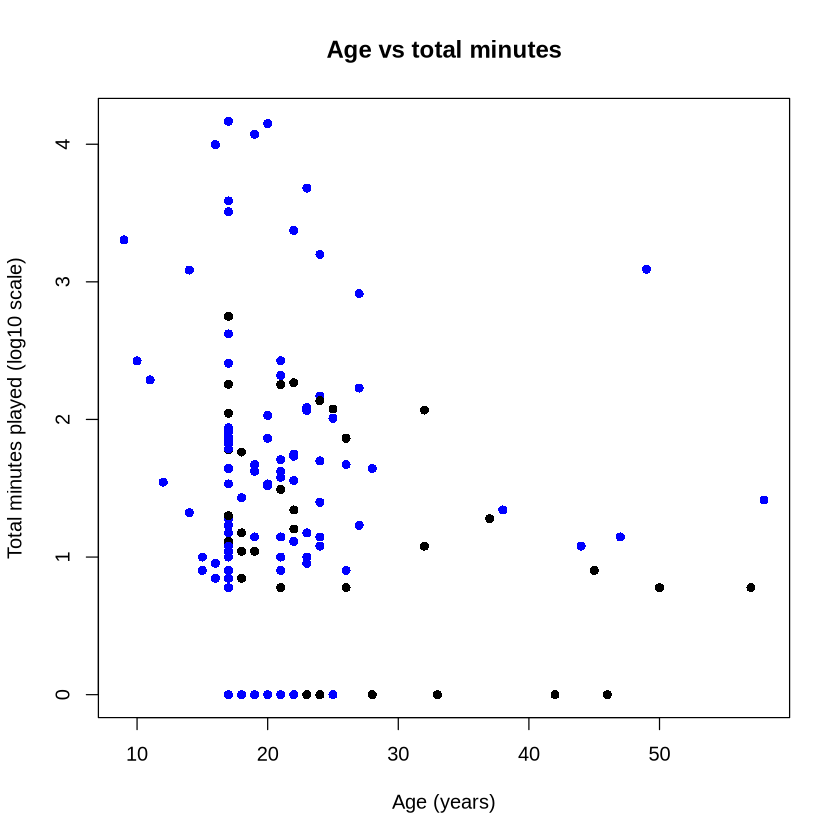

In [5]:
cols <- ifelse(dat$subscribe, "blue", "black")
plot(dat$Age, log10(dat$minutes + 1),
     pch=16, col=cols,
     xlab="Age (years)", ylab="Total minutes played (log10 scale)",
     main="Age vs total minutes")